In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


In [80]:
# Set global matplotlib and seaborn style parameters
import matplotlib as mpl
new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
mpl.rcParams["font.family"] = "Arial"

npg_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF"]
npg_palette2 = ["#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
sns.set_palette(npg_palette)
sns.set_style('white', {'axes.linewidth': 0.85})

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [ ]:
# Load data
df = pd.read_csv('combined_res_singlecopy_ef.txt', sep = '\t')

In [ ]:

# remove genes with missing or non-numeric log2FC
df = df.dropna(subset=['log2FoldChange'])

# pivot the table to wide format: one row per gene, one column per species
pivot_df = df.pivot_table(index='gene', columns='species', values='log2FoldChange')

# drop genes missing in any species
pivot_df = pivot_df.dropna()

# function to compute average pairwise absolute difference (EDS)
def compute_eds(row):
    pairs = list(itertools.combinations(row.index, 2))
    diffs = [abs(row[i] - row[j]) for i, j in pairs]
    return np.mean(diffs)

pivot_df['EDS'] = pivot_df.apply(compute_eds, axis=1)

eds_df = pivot_df[['EDS']]
eds_df.to_csv('eds_ef.csv')

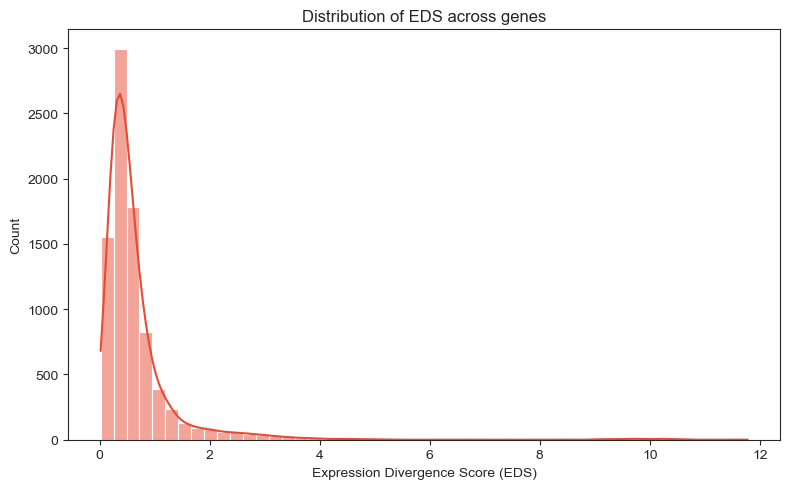

In [5]:
# plot distribution of EDS 
plt.figure(figsize=(8, 5))
sns.histplot(eds_df['EDS'], bins=50, kde=True)
plt.xlabel("Expression Divergence Score (EDS)")
plt.ylabel("Count")
plt.title("Distribution of EDS across genes")
plt.tight_layout()
plt.show()

In [10]:
eds_df

species,EDS
gene,
FBgn0000008,0.440214
FBgn0000014,0.659418
FBgn0000015,0.900274
FBgn0000017,0.634122
FBgn0000018,0.436188
...,...
FBgn0288857,0.220154
FBgn0288875,0.407068
FBgn0288888,0.451380


In [ ]:
# calculate mean baseMean per gene across species
mean_expr = df.groupby('gene')['baseMean'].mean().reset_index()
mean_expr.columns = ['gene', 'mean_baseMean']

In [ ]:
# merge EDS and mean expression
merged = eds_df.reset_index().merge(mean_expr, on='gene')

In [ ]:
gene_status = df[['gene', 'gene_category']]

def summarize_category(categories):
    if 'Upregulated' in categories.values:
        return 'Upregulated'
    else:
        return 'Non-significant'

cat_map = gene_status.groupby('gene')['gene_category'].apply(summarize_category).reset_index()
cat_map.columns = ['gene', 'collapsed_category']

# merge with EDS and mean expression (assuming you've already computed those)
merged = eds_df.merge(mean_expr, on='gene')        # mean_expr from earlier step
merged = merged.merge(cat_map, on='gene')          # now has 'collapsed_category'

In [ ]:
import random

def match_expression_via_annealing_global(merged,
                                          target_category='Upregulated',
                                          control_category='Non-significant',
                                          nsteps=50,
                                          max_iter=1000,
                                          bins=np.arange(0, 16.5, 0.5),
                                          T0=100,
                                          K=0.95,
                                          verbose=True):
    random.seed(42)
    np.random.seed(42)

    # subset the data by category
    target_df = merged[merged['collapsed_category'] == target_category]
    control_df = merged[merged['collapsed_category'] == control_category]

    if len(control_df) < len(target_df):
        print("Not enough control genes to match.")
        return None

    target_expr = np.log1p(target_df['mean_baseMean'].values)
    control_genes = control_df['gene'].tolist()
    control_expr_dict = control_df.set_index('gene')['mean_baseMean'].to_dict()

    target_hist, _ = np.histogram(target_expr, bins=bins, density=True)

    best_match = None
    best_l1 = np.inf

    for step in range(nsteps):
        current_genes = random.sample(control_genes, len(target_df))
        current_expr = np.log1p([control_expr_dict[g] for g in current_genes])
        current_hist, _ = np.histogram(current_expr, bins=bins, density=True)
        l1 = np.sum(np.abs(current_hist - target_hist))
        T = T0

        for it in range(max_iter):
            to_replace = random.randint(0, len(current_genes) - 1)
            candidate = random.choice(list(set(control_genes) - set(current_genes)))
            old_gene = current_genes[to_replace]

            current_genes[to_replace] = candidate
            mutated_expr = np.log1p([control_expr_dict[g] for g in current_genes])
            mutated_hist, _ = np.histogram(mutated_expr, bins=bins, density=True)
            l1_new = np.sum(np.abs(mutated_hist - target_hist))

            accept_prob = 1.0 if l1_new < l1 else np.exp(-(l1_new - l1) / T)
            if random.random() < accept_prob:
                l1 = l1_new
                if l1 < best_l1:
                    best_l1 = l1
                    best_match = current_genes.copy()
            else:
                current_genes[to_replace] = old_gene  # revert

            T *= K

        if verbose:
            print(f"Step {step+1}/{nsteps} | Best L1 diff: {best_l1:.4f}")

    return pd.DataFrame({'gene': best_match})


In [ ]:
matched_df = match_expression_via_annealing_global(merged)

# compare EDS
eds_up = merged[merged['collapsed_category'] == 'Upregulated']['EDS']
eds_matched = merged[merged['gene'].isin(matched_df['gene'])]['EDS']

from scipy.stats import ttest_ind
t, p = ttest_ind(eds_up, eds_matched, equal_var=False)
print(f"t = {t:.3f}, p = {p:.3e}")


Step 1/50 | Best L1 diff: 0.1458
Step 2/50 | Best L1 diff: 0.1458
Step 3/50 | Best L1 diff: 0.1083
Step 4/50 | Best L1 diff: 0.1083
Step 5/50 | Best L1 diff: 0.1083
Step 6/50 | Best L1 diff: 0.1083
Step 7/50 | Best L1 diff: 0.1083
Step 8/50 | Best L1 diff: 0.1083
Step 9/50 | Best L1 diff: 0.1083
Step 10/50 | Best L1 diff: 0.1083
Step 11/50 | Best L1 diff: 0.1083
Step 12/50 | Best L1 diff: 0.1083
Step 13/50 | Best L1 diff: 0.1083
Step 14/50 | Best L1 diff: 0.0833
Step 15/50 | Best L1 diff: 0.0833
Step 16/50 | Best L1 diff: 0.0833
Step 17/50 | Best L1 diff: 0.0833
Step 18/50 | Best L1 diff: 0.0833
Step 19/50 | Best L1 diff: 0.0833
Step 20/50 | Best L1 diff: 0.0833
Step 21/50 | Best L1 diff: 0.0833
Step 22/50 | Best L1 diff: 0.0833
Step 23/50 | Best L1 diff: 0.0833
Step 24/50 | Best L1 diff: 0.0833
Step 25/50 | Best L1 diff: 0.0833
Step 26/50 | Best L1 diff: 0.0833
Step 27/50 | Best L1 diff: 0.0833
Step 28/50 | Best L1 diff: 0.0833
Step 29/50 | Best L1 diff: 0.0833
Step 30/50 | Best L1 di

In [ ]:
# upregulated group
mean_up = eds_up.mean()
median_up = eds_up.median()

# matched non-significant group
mean_matched = eds_matched.mean()
median_matched = eds_matched.median()

print(f"Upregulated genes:    mean = {mean_up:.4f}, median = {median_up:.4f}")
print(f"Matched NS genes:     mean = {mean_matched:.4f}, median = {median_matched:.4f}")

Upregulated genes:    mean = 1.1147, median = 0.9069
Matched NS genes:     mean = 0.6940, median = 0.4590


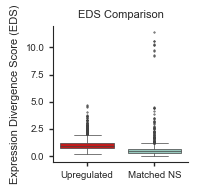

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# build dataframe for plotting
plot_df = pd.DataFrame({
    'EDS': pd.concat([eds_up, eds_matched], ignore_index=True),
    'Group': ['Upregulated'] * len(eds_up) + ['Matched NS'] * len(eds_matched)
})

# create box plot
plt.figure(figsize=(2, 2))
color = [npg_palette2[2], npg_palette2[1]]
ax = sns.boxplot(data=plot_df, x='Group', y='EDS', hue='Group', palette=color, legend=False, linewidth=0.5, flierprops={'markersize': 0.5})

#sns.violinplot(x='Group', y='EDS', data=plot_df, inner=None, linewidth=1, alpha=0.3, palette='Set2')

plt.title('EDS Comparison', fontsize=8)
plt.ylabel('Expression Divergence Score (EDS)', fontsize=8)
plt.xlabel('')
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.despine()
plt.tight_layout()
plt.show()


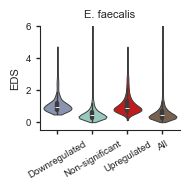

In [ ]:
# merge with EDS values using the 'gene' column
merged_df = df.merge(eds_df, on='gene', how='inner')

# add 'All' category to each row
all_genes_df = merged_df.copy()
all_genes_df['gene_category'] = 'All'

# concatenate with original
extended_df = pd.concat([merged_df, all_genes_df], axis=0)


category_order_extended = ['Downregulated', 'Non-significant', 'Upregulated', 'All']
category_order = ['Downregulated', 'Non-significant', 'Upregulated']

# plot boxplot
plt.figure(figsize=(2, 2))
ax = sns.violinplot(x='gene_category', y='EDS', data=extended_df, hue='gene_category', order=category_order_extended, 
                 hue_order=category_order_extended, palette=npg_palette2[:4], legend=False, cut=0, linewidth=0.7)

plt.xlabel('')
plt.ylabel('EDS', size=8)
plt.title('E. faecalis', size=8)
plt.ylim(-0.5,6)

plt.tick_params(labelsize=7)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
plt.xticks(rotation=30)

sns.despine()
plt.tight_layout()
#plt.show()
#plt.savefig("ef_eds_by_category.svg", dpi=300)


In [7]:
# man-Whitney U test for EDS values by gene category
up = merged_df[merged_df['gene_category'] == 'Upregulated']['EDS']
down = merged_df[merged_df['gene_category'] == 'Downregulated']['EDS']
non = merged_df[merged_df['gene_category'] == 'Non-significant']['EDS']
all = extended_df[extended_df['gene_category'] == 'All']['EDS']

print("Upregulated vs Non-significant:", mannwhitneyu(up, non, alternative='two-sided'))
print("Downregulated vs Non-significant:", mannwhitneyu(down, non, alternative='two-sided'))
print("Upregulated vs Downregulated:", mannwhitneyu(up, down, alternative='two-sided'))


median_eds_by_category = extended_df.groupby('gene_category')['EDS'].median()
print(f"Median EDS by category:{median_eds_by_category}")

Upregulated vs Non-significant: MannwhitneyuResult(statistic=np.float64(40499380.5), pvalue=np.float64(0.0))
Downregulated vs Non-significant: MannwhitneyuResult(statistic=np.float64(24723239.0), pvalue=np.float64(2.578100360181304e-238))
Upregulated vs Downregulated: MannwhitneyuResult(statistic=np.float64(395467.5), pvalue=np.float64(0.059940646249425716))
Median EDS by category:gene_category
All                0.458405
Downregulated      0.982304
Non-significant    0.442316
Upregulated        0.932187
Name: EDS, dtype: float64


In [ ]:
# filter genes that are upregulated in D. virilis
upregulated_virilis = df[(df['species'] == 'dvir') & (df['gene_category'] == 'Upregulated')]

# merge with EDS values
upregulated_virilis = upregulated_virilis.merge(eds_df, on='gene', how='left')

# filter for high EDS genes (e.g., EDS > 1.0)
high_eds_genes = upregulated_virilis[upregulated_virilis['EDS'] > 2]

# sort
high_eds_genes_sorted = high_eds_genes.sort_values(by=['baseMean'], ascending=False)



In [9]:
high_eds_genes_sorted

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_category,species,EDS
1,FBgn0067905,10540.605465,3.288489,0.591869,5.556113,2.758479e-08,3.410061e-06,Upregulated,dvir,2.199652
82,FBgn0034407,6547.540671,11.742792,1.096714,10.707254,9.411211e-27,9.210439e-24,Upregulated,dvir,4.630252
139,FBgn0040582,5438.227023,3.209049,0.235661,13.617228,3.163475e-42,1.857592e-38,Upregulated,dvir,2.674478
38,FBgn0036690,1776.435734,1.280838,0.241711,5.299048,1.164081e-07,1.102497e-05,Upregulated,dvir,2.756479
14,FBgn0035806,1729.534604,2.372713,0.523974,4.528306,5.945855e-06,3.217886e-04,Upregulated,dvir,2.099108
61,FBgn0010385,1365.238249,7.506368,0.813265,9.229914,2.708486e-20,1.767137e-17,Upregulated,dvir,3.708724
11,FBgn0036250,78.696817,1.940210,0.397898,4.876155,1.081735e-06,7.625616e-05,Upregulated,dvir,2.542682
66,FBgn0033778,68.616460,1.415697,0.428336,3.305110,9.493929e-04,1.615067e-02,Upregulated,dvir,2.052749
124,FBgn0038530,45.456692,5.303646,1.437706,3.688963,2.251700e-04,5.969291e-03,Upregulated,dvir,2.353607
7,FBgn0260480,18.489696,1.936921,0.660997,2.930303,3.386321e-03,3.620283e-02,Upregulated,dvir,3.770597


In [ ]:
high_eds_genes_sorted.to_csv('high_eds_upregulated_genes_dvir_ef.txt', sep='\t', index=False)

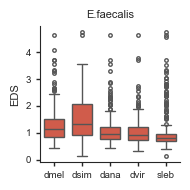

In [ ]:
up_df = merged_df[merged_df['gene_category'] == 'Upregulated']

# plot EDS distribution by species where the gene was upregulated
plt.figure(figsize=(2, 2))
ax = sns.boxplot(x='species', y='EDS', data=up_df, width=0.7, fliersize=2.5)
plt.xlabel("")  # Hide x-axis label
plt.ylabel("EDS", fontsize=8)
plt.title("E.faecalis", fontsize=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# calculate median EDS for upregulated genes by species
median_eds_by_species = up_df.groupby('species')['EDS'].median()
print(median_eds_by_species)

species
dana    0.971945
dmel    1.136880
dsim    1.329517
dvir    0.910980
sleb    0.791212
Name: EDS, dtype: float64


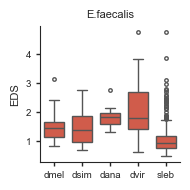

species
dana    1.820595
dmel    1.449009
dsim    1.381127
dvir    1.805814
sleb    0.953687
Name: EDS, dtype: float64


In [ ]:
down_df = merged_df[merged_df['gene_category'] == 'Downregulated']

# plot EDS distribution by species where the gene was upregulated
plt.figure(figsize=(2, 2))
ax = sns.boxplot(x='species', y='EDS', data=down_df, width=0.7, fliersize=2.5)
plt.xlabel("")  # Hide x-axis label
plt.ylabel("EDS", fontsize=8)
plt.title("E.faecalis", fontsize=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.despine()
plt.tight_layout()
plt.show()

# calculate median EDS for upregulated genes by species
median_eds_by_species = down_df.groupby('species')['EDS'].median()
print(median_eds_by_species)

In [ ]:
# correlation plot between EDS and log2FC in D. virilis
virilis_df = merged_df[merged_df['species'] == 'dvir']
virilis_df = virilis_df[virilis_df['EDS'] >2].sort_values(by=['baseMean','log2FoldChange'], ascending=False) 
virilis_df

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_category,species,EDS
32839,FBgn0000427,21948.390875,-1.672729,0.520788,-3.211917,1.318526e-03,1.967569e-02,Downregulated,dvir,2.803058
33247,FBgn0022355,16078.984437,0.631445,0.143914,4.387647,1.145836e-05,5.726257e-04,Non-significant,dvir,2.302775
25491,FBgn0067905,10540.605465,3.288489,0.591869,5.556113,2.758479e-08,3.410061e-06,Upregulated,dvir,2.199652
26489,FBgn0000357,10437.460559,-3.071708,1.671614,-1.837570,6.612578e-02,2.288608e-01,Non-significant,dvir,2.999975
28476,FBgn0034407,6547.540671,11.742792,1.096714,10.707254,9.411211e-27,9.210439e-24,Upregulated,dvir,4.630252
...,...,...,...,...,...,...,...,...,...,...
33955,FBgn0040360,0.085143,-0.444720,4.073066,-0.109186,9.130553e-01,NaN,Non-significant,dvir,2.080539
28097,FBgn0035034,0.070531,0.000000,4.080456,0.000000,1.000000e+00,NaN,Non-significant,dvir,2.955380
29887,FBgn0038993,0.061751,-0.359522,4.076145,-0.088202,9.297165e-01,NaN,Non-significant,dvir,3.440883
30545,FBgn0053340,0.061751,-0.359522,4.076145,-0.088202,9.297165e-01,NaN,Non-significant,dvir,11.374761


# Following are for P. rettgeri

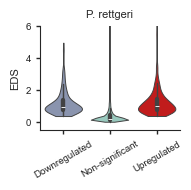

In [ ]:
# Load data
df = pd.read_csv('combined_res_max_pr_filtered_dmel_genes_singlecopy.txt', sep = '\t')

# remove genes with missing or non-numeric log2FC
df = df.dropna(subset=['log2FoldChange'])

# pivot the table to wide format: one row per gene, one column per species
pivot_df = df.pivot_table(index='gene', columns='species', values='log2FoldChange')

# drop genes missing in any species (optional)
pivot_df = pivot_df.dropna()

# function to compute average pairwise absolute difference (EDS)
def compute_eds(row):
    pairs = list(itertools.combinations(row.index, 2))
    diffs = [abs(row[i] - row[j]) for i, j in pairs]
    return np.mean(diffs)

pivot_df['EDS'] = pivot_df.apply(compute_eds, axis=1)

eds_df = pivot_df[['EDS']]
eds_df.to_csv('eds_pr.csv')

# merge with EDS values using the 'gene' column
merged_df = df.merge(eds_df, on='gene', how='inner')

category_order = ['Downregulated', 'Non-significant', 'Upregulated']

# plot boxplot
plt.figure(figsize=(2, 2))
ax = sns.violinplot(x='gene_category', y='EDS', data=merged_df, hue='gene_category', order=category_order, 
                 hue_order=category_order, palette=npg_palette2[:3], legend=False, cut=0, linewidth=0.7)

plt.xlabel('')
plt.ylabel('EDS', size=8)
plt.title('P. rettgeri', size=8)
plt.ylim(-0.5,6)

plt.tick_params(labelsize=7)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
plt.xticks(rotation=30)

sns.despine()
plt.tight_layout()
#plt.show()
#plt.savefig("pr_eds_by_category.svg", dpi=300)

In [157]:
# man-Whitney U test for EDS values by gene category
up = merged_df[merged_df['gene_category'] == 'Upregulated']['EDS']
down = merged_df[merged_df['gene_category'] == 'Downregulated']['EDS']
non = merged_df[merged_df['gene_category'] == 'Non-significant']['EDS']

print("Upregulated vs Non-significant:", mannwhitneyu(up, non, alternative='two-sided'))
print("Downregulated vs Non-significant:", mannwhitneyu(down, non, alternative='two-sided'))
print("Upregulated vs Downregulated:", mannwhitneyu(up, down, alternative='two-sided'))

Upregulated vs Non-significant: MannwhitneyuResult(statistic=np.float64(20015556.0), pvalue=np.float64(4.1235842354288216e-231))
Downregulated vs Non-significant: MannwhitneyuResult(statistic=np.float64(7522734.0), pvalue=np.float64(4.600371807436909e-88))
Upregulated vs Downregulated: MannwhitneyuResult(statistic=np.float64(59697.0), pvalue=np.float64(0.39637943703146616))


In [160]:
median_eds_by_category = merged_df.groupby('gene_category')['EDS'].median()
print(f"Median EDS by category:{median_eds_by_category}")

Median EDS by category:gene_category
Downregulated      0.952061
Non-significant    0.226694
Upregulated        1.042003
Name: EDS, dtype: float64


In [ ]:
# filter genes that are upregulated in D. virilis
upregulated_virilis = df[(df['species'] == 'dvir') & (df['gene_category'] == 'Upregulated')]

# merge with EDS values
upregulated_virilis = upregulated_virilis.merge(eds_df, on='gene', how='left')

# filter for high EDS genes (e.g., EDS > 1.0)
high_eds_genes = upregulated_virilis[upregulated_virilis['EDS'] > 2.0]

# sort
high_eds_genes_sorted = high_eds_genes.sort_values(by='baseMean', ascending=False)


In [165]:
high_eds_genes_sorted.to_csv('high_eds_upregulated_genes_dvir_pr.txt', sep='\t', index=False)

In [164]:
high_eds_genes_sorted

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_category,species,EDS
19,FBgn0039685,3285.515380,1.900888,0.440427,4.316009,1.588756e-05,7.573070e-04,Upregulated,dvir,2.261368
12,FBgn0034407,1788.040510,12.460982,1.131065,11.017030,3.163248e-28,2.789457e-25,Upregulated,dvir,3.428433
7,FBgn0010385,542.331622,9.201453,0.899399,10.230673,1.445114e-24,6.648781e-22,Upregulated,dvir,2.473501
24,FBgn0266569,157.913269,2.636173,0.307992,8.559238,1.136155e-17,2.558041e-15,Upregulated,dvir,2.439981
26,FBgn0033388,123.469044,2.575862,0.243141,10.594107,3.173544e-26,1.767497e-23,Upregulated,dvir,2.130067
25,FBgn0031942,69.640703,1.558664,0.462350,3.371179,7.484711e-04,2.073382e-02,Upregulated,dvir,2.595153
11,FBgn0033830,52.917251,2.274669,0.553531,4.109379,3.967249e-05,1.720550e-03,Upregulated,dvir,2.837687
14,FBgn0063923,26.561330,3.536802,0.753428,4.694282,2.675444e-06,1.482280e-04,Upregulated,dvir,2.160285
21,FBgn0032809,19.602892,1.771778,0.518465,3.417355,6.323277e-04,1.803583e-02,Upregulated,dvir,2.408088


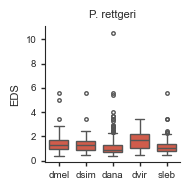

In [ ]:
up_df = merged_df[merged_df['gene_category'] == 'Upregulated']

# plot EDS distribution by species where the gene was upregulated
plt.figure(figsize=(2, 2))
ax = sns.boxplot(x='species', y='EDS', data=up_df, width=0.7, fliersize=2.5)
plt.xlabel("")
plt.ylabel("EDS", fontsize=8)
plt.title("P. rettgeri", fontsize=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# calculate median EDS for upregulated genes by species
median_eds_by_species = up_df.groupby('species')['EDS'].median()
print(median_eds_by_species)

species
dana    0.914376
dmel    1.296343
dsim    1.254012
dvir    1.669865
sleb    1.052916
Name: EDS, dtype: float64


In [ ]:
from scipy.stats import f_oneway

# filter for upregulated genes only
up_df = merged_df[merged_df['gene_category'] == 'Upregulated']

# get EDS values for each species into a list of arrays
groups = [group['EDS'].values for name, group in up_df.groupby('species')]

# run one-way ANOVA
f_stat, p_val = f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat:.3f}")
print(f"ANOVA p-value: {p_val:.3e}")


ANOVA F-statistic: 3.348
ANOVA p-value: 1.009e-02


In [104]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Filter for upregulated genes only
up_df = merged_df[merged_df['gene_category'] == 'Upregulated']

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=up_df['EDS'],
                          groups=up_df['species'],
                          alpha=0.05)

# Print summary
print(tukey.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  dana   dmel   0.2966 0.0784 -0.0199 0.6131  False
  dana   dsim   0.1892   0.64 -0.1857 0.5641  False
  dana   dvir   0.4621 0.0611  -0.013 0.9373  False
  dana   sleb   0.0232 0.9991 -0.2311 0.2776  False
  dmel   dsim  -0.1074 0.9658 -0.5567 0.3419  False
  dmel   dvir   0.1655 0.9162 -0.3703 0.7013  False
  dmel   sleb  -0.2734 0.2183 -0.6284 0.0817  False
  dsim   dvir   0.2729  0.688 -0.2993 0.8452  False
  dsim   sleb   -0.166 0.7995 -0.5739  0.242  False
  dvir   sleb  -0.4389 0.1183 -0.9405 0.0628  False
---------------------------------------------------


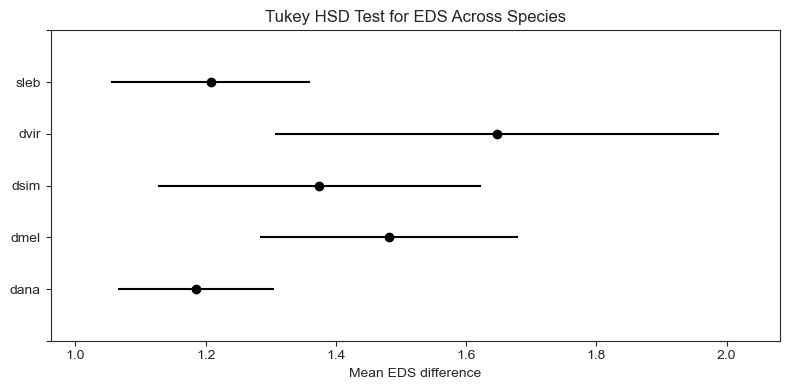

In [105]:
tukey.plot_simultaneous(figsize=(8, 4))
plt.title("Tukey HSD Test for EDS Across Species")
plt.xlabel("Mean EDS difference")
plt.tight_layout()
plt.show()


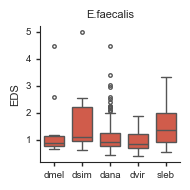

species
dana    0.932076
dmel    0.859036
dsim    1.110693
dvir    0.855946
sleb    1.347393
Name: EDS, dtype: float64


In [ ]:
down_df = merged_df[merged_df['gene_category'] == 'Downregulated']

# plot EDS distribution by species where the gene was upregulated
plt.figure(figsize=(2, 2))
ax = sns.boxplot(x='species', y='EDS', data=down_df, width=0.7, fliersize=2.5)
plt.xlabel("")
plt.ylabel("EDS", fontsize=8)
plt.title("E.faecalis", fontsize=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.despine()
plt.tight_layout()
plt.show()

# calculate median EDS for upregulated genes by species
median_eds_by_species = down_df.groupby('species')['EDS'].median()
print(median_eds_by_species)